In [4]:
import maximum_likelihood
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multinomial

np.random.seed(seed=1)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace"
})

pd.set_option('display.max_rows', None)

MONTE_CARLO_SIZE = 600000
CUTOFF = 0.07
C = 0.147

LOCUS_NAMES = ['UL4', 'UL75', 'UL78', 'US27']

LATEX_TEXTWIDTH = 5.87 # inches

def fit_check(loci):

    data = pd.read_csv("data/data.csv", na_values=["nd", "cov too low", "no cov"])
    studied_loci = [LOCUS_NAMES[i-1] for i in loci]
    n_studied_loci = len(studied_loci)

    type_a_frequencies = (data[LOCUS_NAMES].sum() / data[LOCUS_NAMES].notna().sum())[studied_loci]


    data = data[studied_loci]
    data = data.dropna()

    assert data.notna().all(axis=None)

    n_samples = data.shape[0]



    def cutoff(x, cutofflevel=CUTOFF):
        if x>1-cutofflevel:
            return "1"
        elif x<cutofflevel:
            return "2"
        else:
            return "m"

    data = data.applymap(cutoff)

    data = data.agg("".join, axis=1)

    observed_infection_patterns = data.value_counts().to_dict()


    def standardize_infection_patterns(infection_patterns):
        """ """

        from itertools import product
        li = ["".join(i) for i in product(["1", "2", "m"], repeat=n_studied_loci)]

        for key in li:
            if key not in infection_patterns.keys():
                infection_patterns[key] = 0

        def sorting_function(str):
            """this is highly un-intuitive. We want an ''alphabetical'' ordering of strings with
            the modification that an 'm' has to be between the 'A' and the 'B'."""

            return str[0].replace("1","A").replace("2", "C").replace("m", "B")

        return dict(sorted(infection_patterns.items(), key=sorting_function))

    observed_infection_patterns = standardize_infection_patterns(observed_infection_patterns)


    #print("Type A frequencies:\n")
    #print(type_a_frequencies)

    #print("\nNumbers of mixed loci:\n")
    #print(get_num_mixed_loci_dict(observed_infection_patterns))



    observed_infection_patterns_list = list(observed_infection_patterns.values())
    type_a_frequencies_list = list(type_a_frequencies)



    inferred_weights = maximum_likelihood.get_infection_pattern_weigths_mc(type_a_frequencies_list, C, CUTOFF, MONTE_CARLO_SIZE)


    

    p_value = multinomial_p_value(observed_infection_patterns_list, inferred_weights)
    #print("p-value: ", p_value)

    return observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples


def multinomial_p_value(observation, weights, n_draws=1000000):
        
        N = np.sum(observation)
        
        sample = multinomial.rvs(N, weights, size=n_draws)
        
        probs = multinomial.pmf(sample, N, weights)
        
        prob_observation =  multinomial.pmf(observation, N, weights)
        
        p = (probs<=prob_observation).sum() / n_draws
        
        return p

def count_num_mixed_loci(str):
    return str.count("m")

def get_num_mixed_loci_dict(infection_patterns):
    num_loci = len(studied_loci)
    return {n: sum([v for k, v in infection_patterns.items() if count_num_mixed_loci(k)==n]) for n in range(num_loci+1)}




studied_loci = [1,2]
n_studied_loci = len(studied_loci)


observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)

for i in np.arange(1,5):
    studied_loci = [i]
    print(studied_loci)
    observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
    print("".join([LOCUS_NAMES[i-1] for i in studied_loci])+ ": "+ str(p_value))

for i in np.arange(1,5):
    for j in np.arange(i,5):
        if i == j:
            continue
        else:
            studied_loci = [i,j]
            print(studied_loci)
            observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
            print(", ".join([LOCUS_NAMES[i-1] for i in studied_loci])+ ": "+ str(p_value))

for i in np.arange(1,5):
    for j in np.arange(i,5):
        if i == j:
            continue
        for k in np.arange(j,5):
            if j == k:
                continue
            else:
                studied_loci = [i,j,k]
                print(studied_loci)
                observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
                print(", ".join([LOCUS_NAMES[i-1] for i in studied_loci])+ ": "+ str(p_value))

[1]
UL4: 0.866074
[2]
UL75: 0.983676
[3]
UL78: 0.516476
[4]
US27: 0.761164
[1, 2]
UL4, UL75: 0.851437
[1, 3]
UL4, UL78: 0.681749
[1, 4]
UL4, US27: 0.823326
[2, 3]
UL75, UL78: 0.842988
[2, 4]
UL75, US27: 0.382566
[3, 4]
UL78, US27: 0.936304
[1, 2, 3]
UL4, UL75, UL78: 0.283915
[1, 2, 4]
UL4, UL75, US27: 0.417403
[1, 3, 4]
UL4, UL78, US27: 0.513383
[2, 3, 4]
UL75, UL78, US27: 0.786273


In [5]:
studied_loci = [1,2,3,4]
n_studied_loci = len(studied_loci)


observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
p_value

0.383203

test


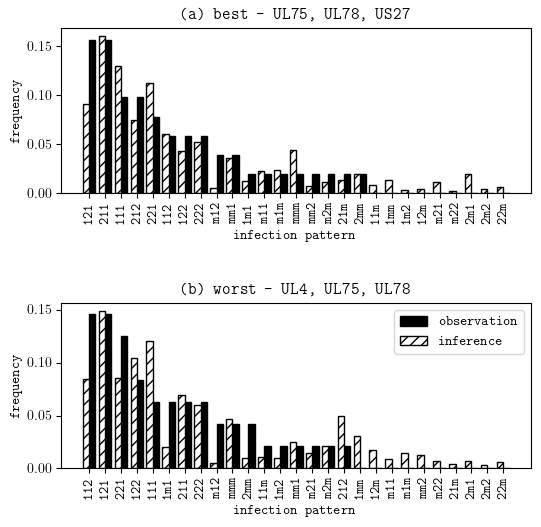

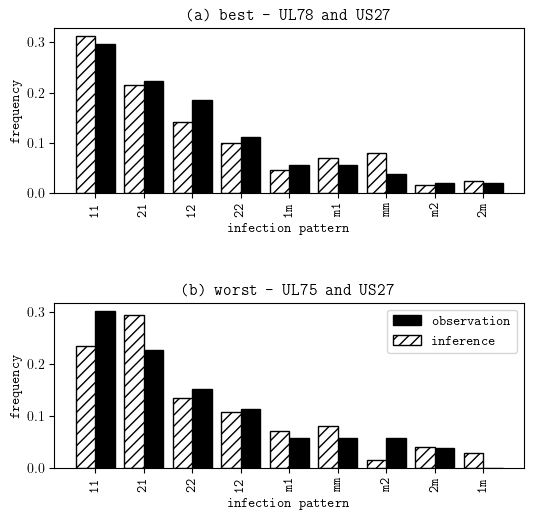

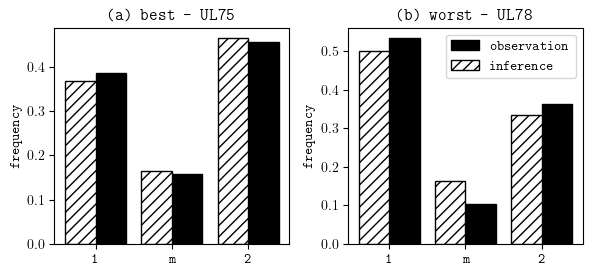

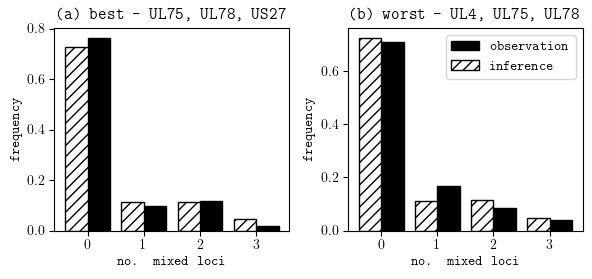

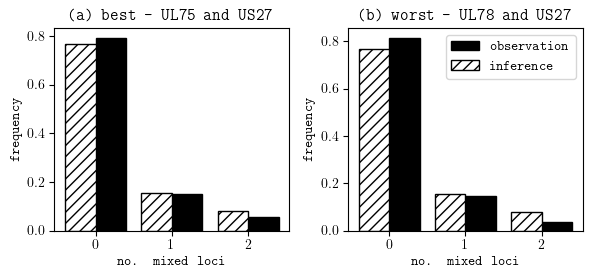

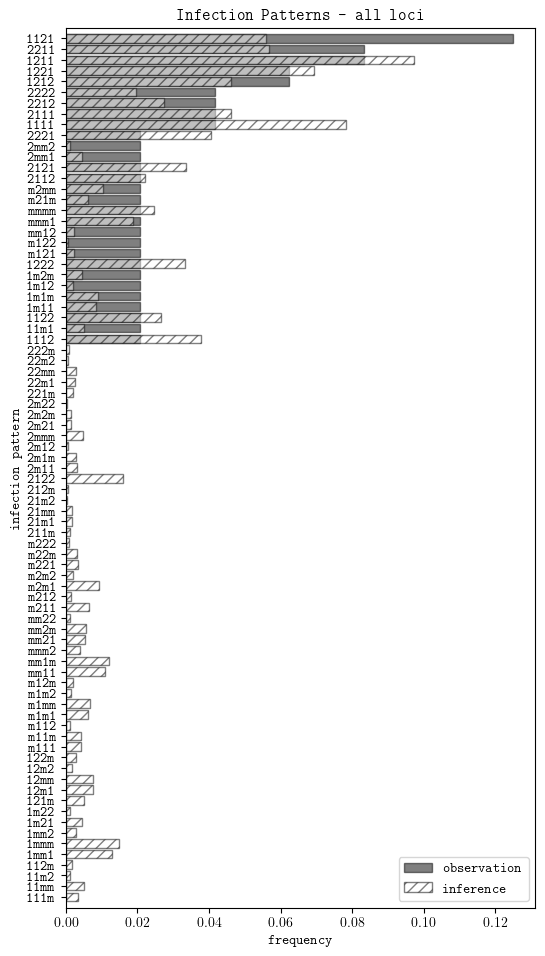

In [6]:
def plot_infection_patterns(ax, observed_infection_patterns, inferred_weights, studied_loci, showlegend=False):
    n_studied_loci = len(studied_loci)


    if n_studied_loci == 1:


        barwidth =  0.4

        ax.bar([0+0.2,1+0.2,2+0.2],  np.array(observed_infection_patterns_list)/n_samples,width=barwidth, color="black", edgecolor="black", label="observation")
        ax.bar([0-0.2,1-0.2,2-0.2], inferred_weights, width=barwidth, hatch="///",edgecolor="black", color="white", label="inference")

        ax.set_xticks([0,1,2])
        ax.set_xticklabels(observed_infection_patterns.keys())

        ax.set_ylabel("frequency")
        ax.set_title("Infection Patterns")

        
    elif n_studied_loci == 2 or n_studied_loci==3:

        x_ticks = np.arange(3**n_studied_loci)


        barwidth = 0.4

        
        sorted_infection_patterns_dict = dict(sorted(observed_infection_patterns.items(), key=lambda item: -item[1]))
        sorted_infection_pattern_weights_dict = {k : v / n_samples for k, v in sorted_infection_patterns_dict.items()}
        C_infection_pattern_weights_dict = dict(zip(maximum_likelihood.generate_index(n_studied_loci), inferred_weights))
        sorted_C_infection_pattern_weights_dict = {k: C_infection_pattern_weights_dict[k] for k in sorted_infection_patterns_dict.keys()}

        ax.bar(x_ticks+0.2, sorted_infection_pattern_weights_dict.values(), width=barwidth,  color="black", edgecolor="black", label="observation")
        ax.bar(x_ticks-0.2, sorted_C_infection_pattern_weights_dict.values(), width=barwidth, hatch="///",edgecolor="black", color="white", label="inference")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(sorted_infection_pattern_weights_dict.keys(), rotation=90)
        ax.set_xlabel("infection pattern")
        ax.set_ylabel("frequency")

        ax.set_title("Infection Patterns")


    elif n_studied_loci == 4:


        sorted_infection_patterns_dict = dict(sorted(observed_infection_patterns.items(), key=lambda item: item[1]))
        sorted_infection_pattern_weights_dict = {k : v / n_samples for k, v in sorted_infection_patterns_dict.items()}
        C_infection_pattern_weights_dict = dict(zip(maximum_likelihood.generate_index(n_studied_loci), inferred_weights))
        sorted_C_infection_pattern_weights_dict = {k: C_infection_pattern_weights_dict[k] for k in sorted_infection_patterns_dict.keys()}
    
        ax.barh(list(sorted_infection_pattern_weights_dict.keys()), sorted_infection_pattern_weights_dict.values(), color="black", edgecolor=(0.0, 0.0, 0.0, 0.5), label="observation", alpha=0.5)
        ax.barh(list(sorted_C_infection_pattern_weights_dict.keys()), sorted_C_infection_pattern_weights_dict.values(), hatch="///",edgecolor="black", color="white", label="inference", alpha=0.5)
        
        ax.set_xlabel("frequency")
        ax.set_ylabel("infection pattern")
        ax.set_ylim(bottom=-1, top=81)
        ax.set_title("Infection Patterns - all loci")

        #fig1.savefig('figures/fit_check_4_loci_infection_patterns.pgf')




    if showlegend:
        ax.legend()

    

def plot_num_mixed_loci(ax, observed_infection_patterns, inferred_weights, studied_loci, showlegend=False):
    n_studied_loci = len(studied_loci)

    if n_studied_loci == 2 or n_studied_loci == 3:
    
        barwidth = 0.4
        x_ticks = np.arange(n_studied_loci+1)

        ax.set_xticks(x_ticks)

        ax.bar(x_ticks+0.2, np.array(list(get_num_mixed_loci_dict(observed_infection_patterns).values()))/n_samples, width=barwidth,  color="black", edgecolor="black", label="observation")
        ax.bar(x_ticks-0.2, get_num_mixed_loci_dict(dict(zip(observed_infection_patterns.keys(), inferred_weights))).values(), width=barwidth, hatch="///",edgecolor="black", color="white", label="inference")
        ax.set_xlabel("no. mixed loci")
        ax.set_ylabel("frequency")

        ax.set_title("Number of mixed Loci")
        
    if showlegend:
        ax.legend()

LATEX_TEXTWIDTH = 5.87 # inches


fig1 = plt.figure(figsize=(LATEX_TEXTWIDTH,5.5))
ax1 = fig1.add_axes([0.1, 0.6, 0.8, 0.3])  # [left, bottom, width, height]
ax2 = fig1.add_axes([0.1, 0.1, 0.8, 0.3])  # [left, bottom, width, height]


studied_loci = [2,3,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax1, observed_infection_patterns, inferred_weights, studied_loci)
ax1.set_title("(a) best - UL75, UL78, US27")

studied_loci = [1,2,3]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax2, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)
ax2.set_title("(b) worst - UL4, UL75, UL78")


fig2 = plt.figure(figsize=(LATEX_TEXTWIDTH,5.5))
ax3 = fig2.add_axes([0.1, 0.6, 0.8, 0.3])  # [left, bottom, width, height]
ax4 = fig2.add_axes([0.1, 0.1, 0.8, 0.3])  # [left, bottom, width, height]

print("test")

studied_loci = [3,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax3, observed_infection_patterns, inferred_weights, studied_loci)
ax3.set_title("(a) best - UL78 and US27")

studied_loci = [2,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax4, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)
ax4.set_title("(b) worst - UL75 and US27")


fig3 = plt.figure(figsize=(LATEX_TEXTWIDTH,2.7))
ax5 = fig3.add_axes([0.08, 0.1, 0.4, 0.8])  # [left, bottom, width, height]
ax6 = fig3.add_axes([0.58, 0.1, 0.4, 0.8])  # [left, bottom, width, height]

studied_loci = [2]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax5, observed_infection_patterns, inferred_weights, studied_loci)
ax5.set_title("(a) best - UL75")


studied_loci = [3]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax6, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)
ax6.set_title("(b) worst - UL78")


fig4 = plt.figure(figsize=(LATEX_TEXTWIDTH,2.7))
ax7 = fig4.add_axes([0.08, 0.15, 0.4, 0.75])  # [left, bottom, width, height]
ax8 = fig4.add_axes([0.58, 0.15, 0.4, 0.75])  # [left, bottom, width, height]


studied_loci = [2,3,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_num_mixed_loci(ax7, observed_infection_patterns, inferred_weights, studied_loci)
ax7.set_title("(a) best - UL75, UL78, US27")

studied_loci = [1,2,3]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_num_mixed_loci(ax8, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)
ax8.set_title("(b) worst - UL4, UL75, UL78")



fig5 = plt.figure(figsize=(LATEX_TEXTWIDTH,2.7))
ax9 = fig5.add_axes([0.08, 0.15, 0.4, 0.75])  # [left, bottom, width, height]
ax10 = fig5.add_axes([0.58, 0.15, 0.4, 0.75])  # [left, bottom, width, height]


studied_loci = [2,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_num_mixed_loci(ax9, observed_infection_patterns, inferred_weights, studied_loci)
ax9.set_title("(a) best - UL75 and US27")

studied_loci = [3,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_num_mixed_loci(ax10, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)
ax10.set_title("(b) worst - UL78 and US27")


fig6 = plt.figure(figsize=(LATEX_TEXTWIDTH,11))
ax11 = fig6.add_axes([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]

studied_loci = [1,2,3,4]
observed_infection_patterns, observed_infection_patterns_list, p_value, inferred_weights, n_samples = fit_check(studied_loci)
plot_infection_patterns(ax11, observed_infection_patterns, inferred_weights, studied_loci, showlegend=True)


#fig1.savefig("figures/fit_inf_pattern_3_loci.pgf")
#fig2.savefig("figures/fit_inf_pattern_2_loci.pgf")
#fig3.savefig("figures/fit_inf_pattern_1_locus.pgf")
#fig4.savefig("figures/fit_mix_loci_3_loci.pgf")
#fig5.savefig("figures/fit_mix_loci_2_loci.pgf")
#fig6.savefig("figures/fit_inf_pattern_4_loci.pgf")